In [178]:
import numpy as np
import pandas as pd
import pickle
#from build_database import flux_obj
from scipy import interpolate
import matplotlib.pyplot as plt
import os
import itertools
import random
import os
import time
import datetime as dt

from spacepy import coordinates as coord
from spacepy.time import Ticktock

from raytracer_utils import readdump, read_rayfile, read_rayfiles
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib inline
%matplotlib nbagg
# Autoload changes made in external editor:
%load_ext autoreload
%autoreload 2

from mpl_toolkits.axes_grid1 import make_axes_locatable


# --------------- Latex Plot Beautification --------------------------
fig_width = 12 
fig_height = 4
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'font.size': 14,
          'legend.fontsize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [450]:
# Here's how to run the c code:
# (this code interpolates rays + damping onto a uniform time axis,
# then calculates geometric spreading at the center of each "tube", defined
# by four corner rays. The result is a measure of wave power density (w/m^2) at
# each timestep. )


ray_inp_dir = '/shared/users/asousa/WIPP/lightning_power_study/rays/globes/ngo_igrf/'
f1 = 2450
f2 = 2860
time_max = 10
num_times = 100
max_ground_distance = 1200
freq_step_size=100
flash_lat = 50
flash_lon = 84
outfile_name= '/shared/users/asousa/WIPP/lightning_power_study/power_vectors_%d_%d.dat'%(f1, f2)

cmd = '../bin/main --ray_dir=%s --out_file=%s'%(ray_inp_dir, outfile_name) + \
        ' --f1=%d --f2=%d --t_max=%g --num_times=%d'%(f1, f2, time_max, num_times) + \
        ' --max_dist=%d --freq_step_size=%d'%(max_ground_distance, freq_step_size) + \
        ' --lat=%d --lon=%d'%(flash_lat, flash_lon)
        
print cmd


ret_val = os.system(cmd)

if ret_val != 0:
    print "C code threw some error... Hmm."
else:
    print "finished!"

../bin/main --ray_dir=/shared/users/asousa/WIPP/lightning_power_study/rays/globes/ngo_igrf/ --out_file=/shared/users/asousa/WIPP/lightning_power_study/power_vectors_2450_2860.dat --f1=2450 --f2=2860 --t_max=10 --num_times=100 --max_dist=1200 --freq_step_size=100 --lat=50 --lon=84
finished!


(4, 21, 8, 4)
Adjacent inds shape: (31, 3)
xz min, max:  -inf -6.86202877349


<IPython.core.display.Javascript object>


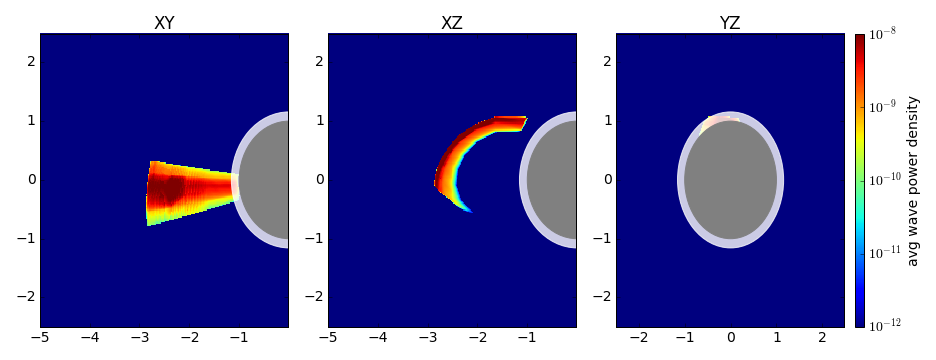

xz min, max:  -inf -6.63494040447


<IPython.core.display.Javascript object>


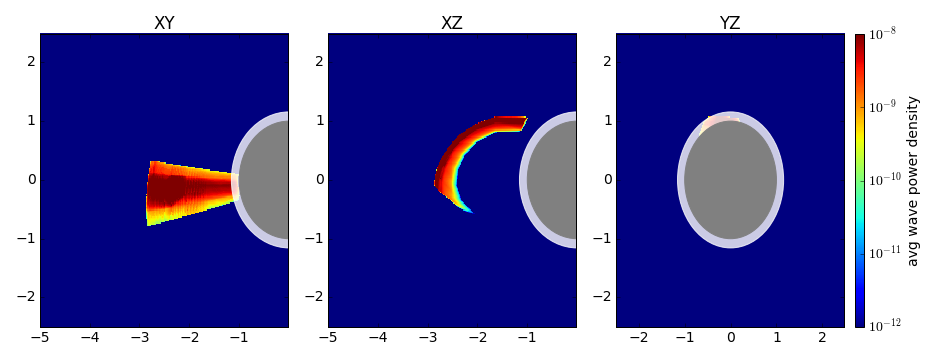

xz min, max:  -inf -6.51621595337


<IPython.core.display.Javascript object>


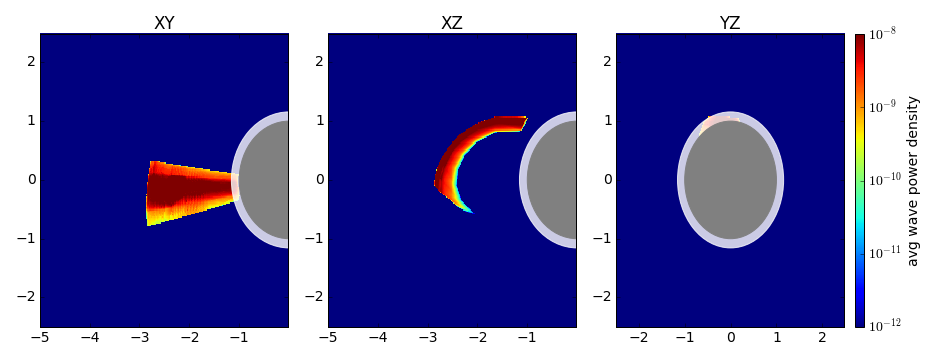

xz min, max:  -inf -6.43562992267


<IPython.core.display.Javascript object>


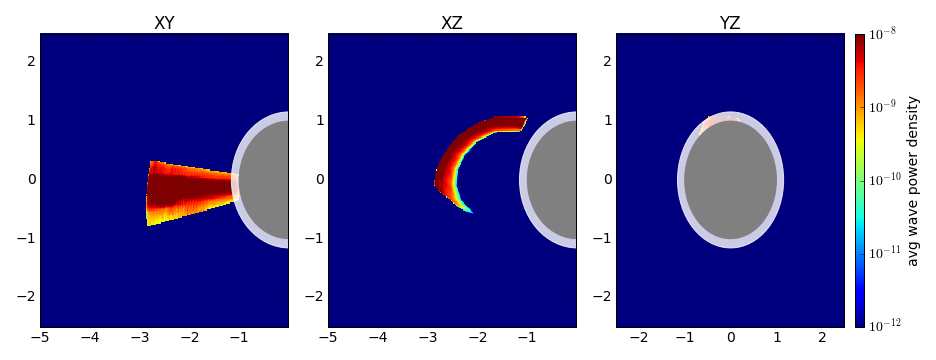

In [451]:
# Load file (sparse list of coordinates + powers, vs time)
# fname = '/shared/users/asousa/WIPP/lightning_power_study/test_dump_prev.dat'
fname = outfile_name
data_raw = np.loadtxt(fname)

R_E = 6371e3
H_IONO = 1000e3
nf = int(data_raw[0]) # num frequencies
nv = int(data_raw[1]) # num vectors
nt = int(data_raw[2]) # num timesteps

dgrid = data_raw[3:]

dgrid = np.reshape(dgrid, [nf,nv,nt,4],order='c')
# dgrid = np.reshape(dgrid, [nf*nv*nt,4],order='c')

print np.shape(dgrid)



import scipy.interpolate
XMIN =-5
XMAX =0
YMIN =-2.5
YMAX =2.5
ZMIN =-2.5
ZMAX =2.5
GRID_STEP_SIZE =0.02

clims = [-12,-8]

xx = np.arange(XMIN, XMAX, GRID_STEP_SIZE)
yy = np.arange(YMIN, YMAX, GRID_STEP_SIZE)
zz = np.arange(ZMIN, ZMAX, GRID_STEP_SIZE)

nx = len(xx) 
ny = len(yy)
nz = len(zz)

data = np.zeros([nx, ny, nz])
# hits = np.zeros([nx, ny, nz])

# Find adjacent sets of power vectors:
# starting_coords = dgrid[0,:,0,0:3]

# print np.shape(starting_coords)
# adj_inds = np.zeros([np.shape(starting_coords)[0],3], dtype='int')

# for r_ind, row in enumerate(starting_coords):
#     dists = np.linalg.norm(row - starting_coords, axis=1)
#     dinds = np.argsort(dists)
#     adj_inds[r_ind,:] = sorted(dinds[0:3])

# sorted_data = adj_inds[np.lexsort(adj_inds.T),:]
# row_mask = np.append([True],np.any(np.diff(sorted_data,axis=0),1))
# adj_inds = sorted_data[row_mask]


starting_coords = dgrid[0,:,0,0:3]
# sc_polar_xf = np.array([xf.c2s(row) for row in starting_coords])
sc_polar = np.array([c2p3(np.array(row)) for row in starting_coords])

# print "mine:"
# print sc_polar*180/np.pi
# print sc_polar_xf
# Delaunay triangulation on lat, lon. 
# (This is a little sloppy since we're taking cartesian distances from
# angular values, but fuck it, it works in this case. Might break elsewhere.)
tris = Delaunay(sc_polar[:,1:3])
adj_inds = np.array(tris.simplices)


print "Adjacent inds shape:", np.shape(adj_inds)
# Interpolate over each little 8-corner box:
for f_ind in range(nf):
    for t in range(0,nt-1):
#         print t
        hits = np.zeros([nx, ny, nz])
        for adj_row in adj_inds:
#             try:
            points = dgrid[f_ind,adj_row,t:t+2,0:3]
            vals = dgrid[f_ind,adj_row,t:t+2,3]
            vals_flat = vals.ravel()
            points_flat = np.vstack([points[:,:,0].ravel(), points[:,:,1].ravel(), points[:,:,2].ravel()]).T
            minx = min(points_flat[:,0])
            maxx = max(points_flat[:,0])
            miny = min(points_flat[:,1])
            maxy = max(points_flat[:,1])
            minz = min(points_flat[:,2])
            maxz = max(points_flat[:,2])

            ix = np.where((xx >= minx) & (xx <= maxx))[0]
            iy = np.where((yy >= miny) & (yy <= maxy))[0]
            iz = np.where((zz >= minz) & (zz <= maxz))[0]

            px, py, pz = np.meshgrid(ix, iy, iz)

            newpoints = np.vstack([xx[px.ravel()], yy[py.ravel()], zz[pz.ravel()]]).T
            newinds   = np.vstack([px, py, pz]).T
            # If we don't specify a fill value, 'linear' mode returns NaN for anything outside
            # the convex hull of the current point cloud (which is ideal -- we don't want any
            # values calculated outside the (non-convex) hull.)
            tmp_data = interpolate.griddata(points_flat, vals_flat, newpoints, method='linear', rescale=False)
            tmp_data = tmp_data.reshape([len(iy), len(ix), len(iz)])
            isnans = np.isnan(tmp_data)
            tmp_data[np.isnan(tmp_data)] = 0

#             print np.sum(isnans), np.sum(~isnans)
            data[px,py,pz] += tmp_data
            hits[px,py,pz] += ~isnans

        data[hits!=0] /= hits[hits!=0]
    
    xz_sum = np.log10((np.sum(data, axis=1).T)/len(yy))
    xy_sum = np.log10((np.sum(data, axis=2).T)/len(zz))
    yz_sum = np.log10((np.sum(data, axis=0).T)/len(xx))
    
    print "xz min, max: ", np.min(xz_sum), np.max(xz_sum)

    xy_sum[np.isinf(xy_sum)] = -100
    xz_sum[np.isinf(xz_sum)] = -100
    yz_sum[np.isinf(yz_sum)] = -100

    fig, ax = plt.subplots(1,3)
    # Plot the earth
    for i in [0, 1, 2]:
        earth = plt.Circle((0,0),1,color='0.5',alpha=1, zorder=100)
        iono  = plt.Circle((0,0),(R_E + H_IONO)/R_E, color='w',alpha=0.8, zorder=99)
        ax[i].add_patch(earth)   
        ax[i].add_patch(iono)
    
    p0 = ax[0].pcolorfast(xx, yy, xy_sum, vmin=clims[0], vmax=clims[1])
    p1 = ax[1].pcolorfast(xx, zz, xz_sum, vmin=clims[0], vmax=clims[1])
    p2 = ax[2].pcolorfast(yy, zz, yz_sum, vmin=clims[0], vmax=clims[1])

    divider = make_axes_locatable(ax[2])
    cax = divider.append_axes("right",size="4%",pad=0.15)
    cb = plt.colorbar(p2, cax=cax)
    cb.set_label('avg wave power density')
    cticks = np.arange(clims[0],clims[1] + 1)
    cb.set_ticks(cticks)
    cticklabels = ['$10^{%d}$'%k for k in cticks]
    cb.set_ticklabels(cticklabels)
    
#     ax[0].set_aspect('equal')
#     ax[1].set_aspect('equal')
#     ax[2].set_aspect('equal')

    ax[0].set_title('XY')
    ax[1].set_title('XZ')
    ax[2].set_title('YZ')
    
    ax[0].set_xlim([xx[0],xx[-1]])
    ax[0].set_ylim([yy[0],yy[-1]])
    ax[1].set_xlim([xx[0],xx[-1]])
    ax[1].set_ylim([zz[0],zz[-1]])
    ax[2].set_xlim([yy[0],yy[-1]])
    ax[2].set_ylim([zz[0],zz[-1]])
    
    
    

    
    fig.tight_layout()



<IPython.core.display.Javascript object>


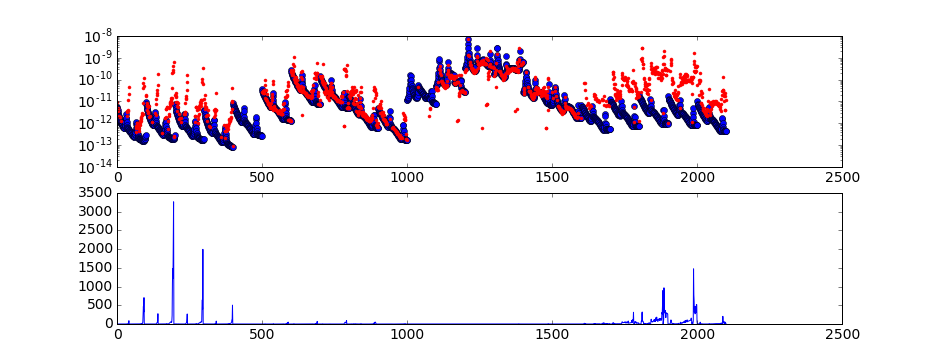

In [449]:
# Check how well it matches with the known data:

# Find closest values in interpolated grid to the current rays:

xraw = dgrid[:,:,:,0].ravel()
yraw = dgrid[:,:,:,1].ravel()
zraw = dgrid[:,:,:,2].ravel()
data_raw = dgrid[:,:,:,3].ravel()

# Quantize to our sampling grid
xq   = np.digitize(xraw, xx)
yq   = np.digitize(yraw, yy)
zq   = np.digitize(zraw, zz)

dq = data[xq, yq, zq]

fig, ax = plt.subplots(2,1)

ax[0].semilogy(data_raw,'bo')
ax[0].semilogy(dq,'r.')

ax[1].plot(abs(data_raw - dq)/abs(data_raw))


In [304]:
def haversine_distance(latitude1, longitude1, latitude2, longitude2):
#     // Great-circle distance between two pairs of (lat, lon), in degrees.
    D2R=np.pi/180.
    lat1 = D2R*latitude1;
    lon1 = D2R*longitude1;
    lat2 = D2R*latitude2;
    lon2 = D2R*longitude2;

    d_lat = abs(lat1 - lat2);
    d_lon = abs(lon1 - lon2);

    a = pow(np.sin(d_lat / 2), 2) + np.cos(lat1) * np.cos(lat2) * pow(np.sin(d_lon / 2), 2);

    d_sigma = 2 * np.arcsin(np.sqrt(a));

    return R_E * d_sigma;


In [418]:
# starting_coords = dgrid[0,:,0,0:3]

# print np.shape(starting_coords)
adj_inds = np.zeros([np.shape(starting_coords)[0],3])

starting_coords_polar = np.array([xf.c2s(row) for row in starting_coords])
# print starting_coords_polar

for r_ind, row in enumerate(starting_coords_polar):
# for r_ind, row in enumerate(starting_coords):
    
    dists = [haversine_distance(row[1], row[2], rother[1], rother[2]) for rother in starting_coords_polar]
#     dists = np.linalg.norm(row - starting_coords, axis=1)
    dinds = np.argsort(dists)
    adj_inds[r_ind,:] = sorted(dinds[0:3])
#     print dists

sorted_data = adj_inds[np.lexsort(adj_inds.T),:]
row_mask = np.append([True],np.any(np.diff(sorted_data,axis=0),1))
adj_inds = np.array(sorted_data[row_mask], dtype=int)

print np.shape(adj_inds)
print adj_inds

# print row


# points = dgrid[f_ind,row,t-1:t+2,0:3]

(16, 3)
[[ 0  1  2]
 [ 0  1  4]
 [ 3  4  5]
 [ 1  2  6]
 [ 4  5  6]
 [ 5  6  7]
 [ 3  4  8]
 [ 3  8  9]
 [ 8  9 10]
 [ 9 10 11]
 [ 6  7 12]
 [ 7 11 12]
 [10 11 12]
 [ 9 13 14]
 [11 14 15]
 [13 14 15]]


In [436]:
def c2s3(din):
#     print din
    dout = np.zeros_like(din)
    dout[0] = np.linalg.norm(din)
    dout[1] = np.arctan2(din[1],din[0])
    dout[2] = np.arctan2(np.sqrt(din[0]**2 + din[1]**2),din[2])
    return dout
def s2c3(din):
    dout = np.zeros_like(din)
    dout[0] = din[0]*np.cos(din[1])*np.sin(din[2])
    dout[1] = din[0]*np.sin(din[1])*np.sin(din[2])
    dout[2] = din[0]*np.cos(din[2])
    return dout



def c2p3(din):
    # Cartesian to spherical (rad). Matches the fortran CART_TO_POL method
    dout = np.zeros_like(din)

    row=np.sqrt(din[0]**2+din[1]**2)
    dout[0]=np.sqrt(row*row+din[2]**2)
    dout[1]=np.arctan2(din[2],row)
    dout[2]=np.arctan2(din[1],din[0])
    dout[2]+= + (1.0 -np.sign(dout[2]))*np.pi
    
    
#     dout = np.zeros_like(din)
#     dout[0] = np.linalg.norm(din)
#     dout[1] = np.arctan2(din[1],din[0])
#     dout[2] = np.arctan2(np.sqrt(din[0]**2 + din[1]**2),din[2])
    return dout

def p2c3(din):
    # Spherical to cartesian (rad)
    dout = np.zeros_like(din)
    dout[0] = din[0]*np.cos(din[1])*np.cos(din[2])
    dout[1] = din[0]*np.cos(din[1])*np.sin(din[2])
    dout[2] = din[0]*np.sin(din[1])
    return dout

# print starting_coords
sc_polar = np.array([c2p3(np.array(row)) for row in starting_coords])
print sc_polar
sc_cart = [p2c3(np.array(row)) for row in sc_polar]
print sc_cart - starting_coords


[[ 1.23177648  0.71389301  3.15020169]
 [ 1.23311955  0.7144517   3.23660229]
 [ 1.23454669  0.71507797  3.32316125]
 [ 1.24422406  0.79974427  3.06369441]
 [ 1.24524935  0.80012541  3.14984604]
 [ 1.24630597  0.80064264  3.23615787]
 [ 1.24746989  0.80121104  3.32260659]
 [ 1.24869686  0.8018152   3.40921471]
 [ 1.26310697  0.8798824   3.06311188]
 [ 1.26397152  0.88019871  3.14903623]
 [ 1.26489681  0.88062665  3.23512957]
 [ 1.26573166  0.88125135  3.3213794 ]
 [ 1.26669265  0.88189882  3.40780963]
 [ 1.27672511  0.95399962  3.14793332]
 [ 1.27753533  0.9541337   3.23369979]
 [ 1.27825581  0.95446145  3.31963029]]
[[  0.00000000e+00   4.31946146e-16   1.11022302e-16]
 [  0.00000000e+00   8.32667268e-17   0.00000000e+00]
 [  0.00000000e+00   2.22044605e-16   0.00000000e+00]
 [  0.00000000e+00   5.55111512e-17   0.00000000e+00]
 [  1.11022302e-16   4.68375339e-17   0.00000000e+00]
 [ -1.11022302e-16   3.74700271e-16   0.00000000e+00]
 [  0.00000000e+00   1.94289029e-16  -1.11022302e-1

mine:
[[  70.57559354   40.90305648  180.49326148]
 [  70.65254576   40.93506719  185.44365117]
 [  70.73431521   40.97094997  190.40311419]
 [  71.28878746   45.82197153  175.53675943]
 [  71.34753222   45.84380897  180.47288394]
 [  71.40807193   45.87344397  185.41818765]
 [  71.4747595    45.90601084  190.37133479]
 [  71.54506015   45.94062669  195.33361425]
 [  72.37069817   50.41354826  175.50338317]
 [  72.42023351   50.43167106  180.4264855 ]
 [  72.47324889   50.45619064  185.35927077]
 [  72.52108211   50.49198282  190.3010216 ]
 [  72.57614292   50.52908011  195.25310918]
 [  73.15096053   54.66015167  180.36329371]
 [  73.19738264   54.66783433  185.27735017]
 [  73.23866314   54.68661257  190.20080507]]
[[   1.23177648   40.90305648  180.49326148]
 [   1.23311955   40.93506719  185.44365117]
 [   1.23454669   40.97094997  190.40311419]
 [   1.24422406   45.82197153  175.53675943]
 [   1.24524935   45.84380897  180.47288394]
 [   1.24630597   45.87344397  185.41818765]
 [ 

<IPython.core.display.Javascript object>


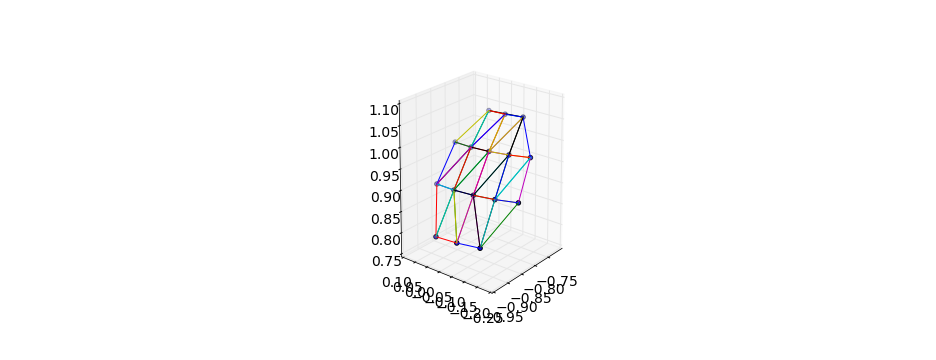

In [437]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import Delaunay  # Triangle finder!

def c2p3(din):
    # Cartesian to spherical (rad). Matches the fortran CART_TO_POL method
    dout = np.zeros_like(din)

    row=np.sqrt(din[0]**2+din[1]**2)
    dout[0]=np.sqrt(row*row+din[2]**2)
    dout[1]=np.arctan2(din[2],row)
    dout[2]=np.arctan2(din[1],din[0])
    dout[2]+= + (1.0 -np.sign(dout[2]))*np.pi
    
    
#     dout = np.zeros_like(din)
#     dout[0] = np.linalg.norm(din)
#     dout[1] = np.arctan2(din[1],din[0])
#     dout[2] = np.arctan2(np.sqrt(din[0]**2 + din[1]**2),din[2])
    return dout

def p2c3(din):
    # Spherical to cartesian (rad)
    dout = np.zeros_like(din)
    dout[0] = din[0]*np.cos(din[1])*np.cos(din[2])
    dout[1] = din[0]*np.cos(din[1])*np.sin(din[2])
    dout[2] = din[0]*np.sin(din[1])
    return dout


# Get indexes of all available triangles at starting time index.
# Do the computation in 2D projection to avoid weird layered hits.

f_ind = 0;

starting_coords = dgrid[0,:,0,0:3]
# sc_polar_xf = np.array([xf.c2s(row) for row in starting_coords])
sc_polar = np.array([c2p3(np.array(row)) for row in starting_coords])

print "mine:"
# print sc_polar*180/np.pi
# print sc_polar_xf
# Delaunay triangulation on lat, lon. 
# (This is a little sloppy since we're taking cartesian distances from
# angular values, but fuck it, it works in this case. Might break elsewhere.)
tris = Delaunay(sc_polar[:,1:3])
adj_inds = np.array(tris.simplices)

# print np.shape(adj_inds)

# print adj_inds
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(starting_coords[:,0], starting_coords[:,1], starting_coords[:,2],'b.')

# Draw lines between each point:
for row in adj_inds:
    coords = starting_coords[np.hstack([row, row[0]]),:]

    ax.plot(coords[0:2,0],coords[0:2,1],coords[0:2,2])
    ax.plot(coords[1:3,0],coords[1:3,1],coords[1:3,2])
    ax.plot(coords[2:4,0],coords[2:4,1],coords[2:4,2])

ax.set_aspect('equal')


(1, 16, 100, 4)


<IPython.core.display.Javascript object>


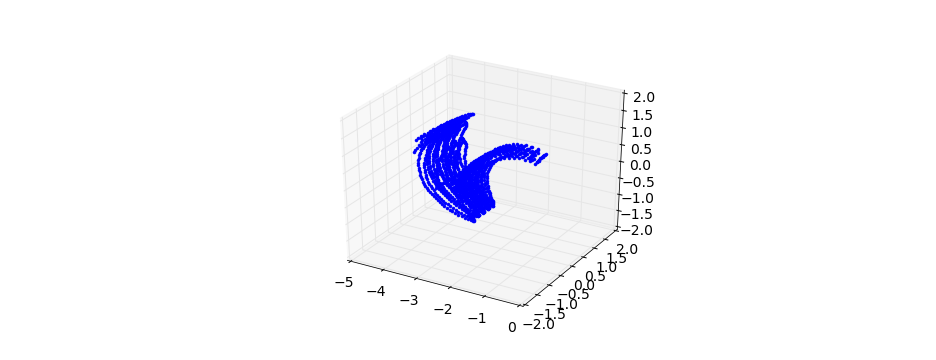

(-2, 2)

In [246]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Handy 3d plotter to show where the original power samples are:

# Load file (sparse list of coordinates + powers, vs time)
# fname = '/shared/users/asousa/WIPP/lightning_power_study/test_dump_prev.dat'

data_raw = np.loadtxt(outfile_name)

nf = int(data_raw[0]) # num frequencies
nv = int(data_raw[1]) # num vectors
nt = int(data_raw[2]) # num timesteps

dgrid = data_raw[3:]

dgrid = np.reshape(dgrid, [nf,nv,nt,4],order='c')
# dgrid = np.reshape(dgrid, [nf*nv*nt,4],order='c')

print np.shape(dgrid)


f_ind = 0;




fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for v in range(nv):
    ax.plot(dgrid[0,v,:,0],dgrid[0,v,:,1],dgrid[0,v,:,2],'b.')

# ax.plot(dgrid[:,0],dgrid[:,1],dgrid[:,2],'b.')


ax.set_aspect('equal')
ax.set_xlim([-5,0])
ax.set_ylim([-2,2])
ax.set_zlim([-2,2])


In [365]:
from scipy.spatial import Delaunay

points = starting_coords

tris = Delaunay(points)
inps = np.array(tris.simplices)
sorted_data = np.array([sorted(fuck) for fuck in inps])

row_mask = np.append([True],np.any(np.diff(sorted_data,axis=0),1))
adj_inds = np.array(sorted_data[row_mask], dtype=int)
# print sorted_data
# print np.shape(adj_inds)
print adj_inds
print np.shape(adj_inds)



[[ 0  1  2  7]
 [ 0  3  5  7]
 [ 3  6  7 15]
 [ 3  5  6 15]
 [ 3  5  6  7]
 [ 5  6 11 15]
 [ 6  7 12 15]
 [ 6 11 12 15]
 [ 6  7 11 12]
 [ 1  2  6  7]
 [ 1  2  5  6]
 [ 0  1  6  7]
 [ 0  5  6  7]
 [ 0  1  5  6]
 [ 5  6 10 11]
 [10 11 14 15]
 [ 5 11 14 15]
 [ 5 10 11 14]
 [ 3  4  5 15]
 [ 3  4 13 15]
 [ 4  5 10 14]
 [ 4 10 13 14]
 [ 0  3  4  5]
 [ 4  5 14 15]
 [ 4 13 14 15]
 [ 0  1  4  5]
 [ 4  9 10 13]
 [ 3  8  9 13]
 [ 3  4  9 13]
 [ 3  4  8  9]
 [ 9 10 13 14]
 [ 4  5  9 10]]
(32, 4)
